# Using NetworkX for connectivity metrics



In [1]:
%%capture
# Install dotmotif with one line.
# On your own computer, you can run this in the terminal.
!pip3 install dotmotif networkx
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import pandas
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm



In [2]:

from lsmm_data import LSMMData
import json

with open('v1dd_data_structures_information.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings
 
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])
 
pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']

Filtering to 10 cells per type
Generating Connectome...


100%|██████████| 132646/132646 [04:25<00:00, 500.32it/s] 


Generating Connectome...


100%|██████████| 132646/132646 [02:26<00:00, 902.89it/s] 


     index      id          pt_root_id  pt_position_x  pt_position_y  \
0        9  293764  864691132625300120         878665         697702   
1       41  295576  864691132710501931         842193         737122   
2       62  278405  864691132830575876         737898         601710   
3       85  307952  864691132999200949         867646         840563   
4       93  366542  864691132834421640         923130         760946   
..     ...     ...                 ...            ...            ...   
812   8764  371302  864691132849454803         958050         629957   
813   8769  385115  864691132679146333         975354         850418   
814   8773  383491  864691132763271347         928872         797418   
815   8790  351167  864691132579592205         927863         548865   
816   8794  277788  864691132653866455         853833         547235   

     pt_position_z classification_system cell_type status_axon  \
0           245475            excitatory        4P    extended   
1  

In [4]:
'''def calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):
    pre_cell_pt_index = pre_cells['pt_root_id']
    post_cell_pt_index = post_cells['pt_root_id']
    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]
    pre_cell_pt_index = pre_cell_pt_index.to_list()
    post_cell_pt_index = post_cell_pt_index.to_list()

    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))
    for synapse in tqdm(range(len(synapses))):
        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])
        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])
        if use_sizes:
            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']
        else:
            synapse_connectome[preidx,postidx] += 1
    return synapse_connectome'''

In [3]:
cell_table = tables['structural']['pre_cell']

weight_matrix = tables['structural']['summed_size_connectome']


adjacency_matrix = weight_matrix.clip(0,1)
#np.fill_diagonal(adjacency_matrix, 0)
all_to_all_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

In [5]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
cell_table

,index,id,pt_root_id,pt_position_x,pt_position_y,pt_position_z,classification_system,cell_type,status_axon,pt_position_x_trafo,...,dist_pia,dist_1-23,dist_23-4,dist_4-5,dist_5-6,dist_WM,full_dendrite,cell_type_v2,connectome_index,pt_position
0,9,293764,864691132625300120,878665,697702,245475,excitatory,4P,extended,-17654.153169,...,348299.261582,248299.261582,78299.261582,51700.738418,201700.738418,401700.738418,True,4P,0,"[878665, 697702, 245475]"
1,41,295576,864691132710501931,842193,737122,325260,inhibitory,ProxTC,extended,-67856.489452,...,407818.941194,307818.941194,137818.941194,7818.941194,142181.058806,342181.058806,True,ProxTC-L5,1,"[842193, 737122, 325260]"
2,62,278405,864691132830575876,737898,601710,294075,inhibitory,DistTC,extended,-145995.980100,...,269521.726886,169521.726886,478.273114,130478.273114,280478.273114,480478.273114,True,DistTC-L23,2,"[737898, 601710, 294075]"
3,85,307952,864691132999200949,867646,840563,262935,excitatory,5P,extended,-69027.465946,...,490673.563262,390673.563262,220673.563262,90673.563262,59326.436738,259326.436738,True,5P,3,"[867646, 840563, 262935]"
4,93,366542,864691132834421640,923130,760946,173250,inhibitory,DistTC,extended,17492.220187,...,389679.613276,289679.613276,119679.613276,10320.386724,160320.386724,360320.386724,False,DistTC-L4,4,"[923130, 760946, 173250]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,8764,371302,864691132849454803,958050,629957,382545,inhibitory,ProxTC,extended,67043.559779,...,319323.746587,219323.746587,49323.746587,80676.253413,230676.253413,430676.253413,True,ProxTC-L4,812,"[958050, 629957, 382545]"
813,8769,385115,864691132679146333,975354,850418,394650,excitatory,6P,extended,17544.597851,...,534890.730711,434890.730711,264890.730711,134890.730711,15109.269289,215109.269289,True,6P,813,"[975354, 850418, 394650]"
814,8773,383491,864691132763271347,928872,797418,316125,excitatory,5P,extended,3578.299784,...,463037.004450,363037.004450,193037.004450,63037.004450,86962.995550,286962.995550,True,5P,814,"[928872, 797418, 316125]"
815,8790,351167,864691132579592205,927863,548865,192105,inhibitory,ProxTC,extended,51726.443534,...,190364.527692,90364.527692,79635.472308,209635.472308,359635.472308,559635.472308,False,ProxTC-L23,815,"[927863, 548865, 192105]"


#**NETWORKX METRICS CHECK**

In [8]:
# Calculate metrics
CC = nx.average_clustering(all_to_all_graph)  # clustering coefficient

L = nx.average_shortest_path_length(all_to_all_graph)  # Average shortest path length

# Generate a random graph with the same number of nodes and edges
G_rand = nx.gnm_random_graph(all_to_all_graph.number_of_nodes(), all_to_all_graph.number_of_edges(), directed=True)

# Calculate random metrics
CC_rand = nx.average_clustering(G_rand)  # Random clustering coefficient
L_rand = nx.average_shortest_path_length(G_rand.to_directed())  # Random average shortest path length

# Calculate small-worldness
sigma = (CC / CC_rand) * (L_rand / L)


# Print results
print("Out-degree Clustering Coefficient (CC_out):", CC)
#print("In-degree Clustering Coefficient (CC_in):", CC_in)
print("Average Shortest Path Length (L):", L)
print("Random Clustering Coefficient (CC_rand):", CC_rand)
print("Random Average Shortest Path Length (L_rand):", L_rand)
print("Small-Worldness (σ):", sigma)

NetworkXError: Graph is not strongly connected.

#CENTRALITY: 
Degree centrality, in-degree centrality, out-degree centrality, closeness centrality

In [9]:
centrality = nx.degree_centrality(all_to_all_graph)
indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph)

In [11]:
cell_table['centrality'] = centrality
cell_table['indegree_centrality'] = indegree_centrality
cell_table['outdegree_centrality'] = outdegree_centrality
cell_table['closeness_centrality'] = closeness_centrality

In [12]:
assemblies_by_connectome_index = mappings['assemblies_by_connectome_index']    #Assembly number for the cell in the connectome

In [13]:
assemblies_by_connectome_index

{361: ['A 1'],
 288: ['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8'],
 9: ['A 1'],
 604: ['A 1', 'A 5', 'A 7', 'A 10'],
 439: ['A 1', 'A 3'],
 117: ['A 1'],
 717: ['A 1', 'A 4', 'A 7', 'A 8'],
 153: ['A 1', 'A 4', 'A 7', 'A 8'],
 212: ['A 1', 'A 2', 'A 8'],
 515: ['A 1', 'A 3'],
 670: ['A 1'],
 411: ['A 1', 'A 3', 'A 5'],
 636: ['A 1', 'A 2', 'A 3'],
 338: ['A 1', 'A 6'],
 407: ['A 1'],
 116: ['A 1', 'A 4'],
 190: ['A 1', 'A 6'],
 25: ['A 1', 'A 3', 'A 4'],
 802: ['A 1', 'A 2'],
 314: ['A 1', 'A 6'],
 730: ['A 1', 'A 3', 'A 8'],
 65: ['A 2', 'A 11'],
 101: ['A 2'],
 435: ['A 2'],
 698: ['A 2', 'A 10'],
 767: ['A 2', 'A 4', 'A 5'],
 375: ['A 2', 'A 10'],
 289: ['A 3'],
 216: ['A 3', 'A 7', 'A 8'],
 358: ['A 3'],
 50: ['A 4'],
 632: ['A 4'],
 772: ['A 4', 'A 5', 'A 7', 'A 8'],
 152: ['A 4', 'A 5', 'A 7', 'A 8'],
 684: ['A 5', 'A 7'],
 230: ['A 5'],
 810: ['A 6'],
 540: ['A 9', 'A 12'],
 607: ['A 9'],
 69: ['A 10'],
 696: ['A 10'],
 679: ['A 13', 'A 15'],
 284: ['A 14'],
 573: ['No A'],
 242: 

In [14]:
def get_indices_and_assemblies(assemblies_by_connectome_index):
   cells_index = []    #connectome index of cell
   assembly_id = []    #assembly id

   for cell in assemblies_by_connectome_index:
      cells_index.append(cell)

   for assembly in assemblies_by_connectome_index.values():
      assembly_id.append(assembly)
   '''for assembly in cell_indices_by_assemblies:
       for cell in cell_indices_by_assemblies[assembly]:
        cells_index.append(cell)
        assembly_id.append(assembly)'''

   return cells_index, assembly_id



In [15]:

cell_idx, assembly_id = get_indices_and_assemblies(assemblies_by_connectome_index)

#sort the indices and assembly id - make a new dataframe
cell_index_and_assembly = pandas.DataFrame()
cell_index_and_assembly['cell_index'] = cell_idx
cell_index_and_assembly['assembly_id'] = assembly_id

In [18]:
cell_index_and_assembly


,cell_index,assembly_id
0,361,[A 1]
1,288,"[A 1, A 3, A 4, A 5, A 7, A 8]"
2,9,[A 1]
3,604,"[A 1, A 5, A 7, A 10]"
4,439,"[A 1, A 3]"
5,117,[A 1]
6,717,"[A 1, A 4, A 7, A 8]"
7,153,"[A 1, A 4, A 7, A 8]"
8,212,"[A 1, A 2, A 8]"
9,515,"[A 1, A 3]"


In [ ]:
#cell_index_and_assembly = cell_index_and_assembly.groupby('cell_index')['assembly_id'].apply(list).reset_index()

In [31]:

def get_assemblyIndex_for_Connectome_cells(cell_table, cell_index_and_assembly):
 connectome_assembly_id = []   #assembly id for all the cells in a connectome
 #non_assembly_cell_in_connectome = []
 #assembly_cell_not_in_connectome = []
 assembly_cell=[]   #a cell that is present in an assembly-------derived from assemblies by connectome index
 for i in range(len(cell_table)):
     connectome_assembly_id.append([])      
 assembly_id_for_cells_in_assemblies = []
 cells_in_assemblies = []   #connectome cells that belong to an assembly
 for cellIndex, assemblyMembershiplist in zip(cell_index_and_assembly['cell_index'],cell_index_and_assembly['assembly_id']):
  for index, cell in enumerate(cell_table['connectome_index']):
    if cellIndex == cell:
      connectome_assembly_id[index] = assemblyMembershiplist      #add the assembly id to the empty list at that connectome index
      assembly_id_for_cells_in_assemblies.append(assemblyMembershiplist)     #this should be equal to cell_index_and_assembly['assembly_id'] 
      cells_in_assemblies.append(cell)   #this should be equal to cell_index_and_assembly['cell_index'] ---- value from cell_table
      assembly_cell.append(cellIndex)    #should match with cells_in_assemblies---- value from 'table'
  
 #return(connectome_assembly_id, assembly_id_for_cells_in_assemblies, cells_in_assemblies, assembly_cell)

 return(connectome_assembly_id)


In [32]:
connectome_assembly_id = get_assemblyIndex_for_Connectome_cells(cell_table, cell_index_and_assembly)



In [33]:
cell_table['assembly_id'] = connectome_assembly_id #add assembly id for each cell in the connectome to the main cell table


In [36]:
cell_table['assembly_id'][83] #[check]

['No A']

In [174]:
''''for cell, index in zip(cell_index_and_assembly['cell_index'], cell_index_and_assembly['assembly_id']):
    if cell not in cells_in_assemblies: #all connectome cells in assemblies:
        print(cell) # all cells in assemblies not in the connectime 
        print(index)

In [37]:
len(assembly_id_for_cells_in_assemblies)

55

In [86]:
#TRIAL CHECK FOR 'AND' 'OR' LOGIC
''''cells = ['A 1', 'A 1', 'A 1', 'A 1','0']

for idx in cells:
    print(idx != 'A 1')
    print(idx != '0')
    print(idx != 'A 1' or idx != '0')
    print(idx != 'A 1' and idx != '0')


False
True
True
False
False
True
True
False
False
True
True
False
False
True
True
False
True
False
True
False


This shows that OR will always be TRUE!

In [39]:
#plots

#----------DEGREE CENTRALITY------------------------
centrality_assembly_cells = []
centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, cent in zip(cell_table['assembly_id'], cell_table['centrality']):
  if idx != ['No A']:    
   #print(idx)
   #print(idx)
   centrality_assembly_cells.append(cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    centrality_non_assembly_cells.append(cent)



In [41]:
for i in idx_check_non_assembly:
    if i != ['No A']:
        print(i)

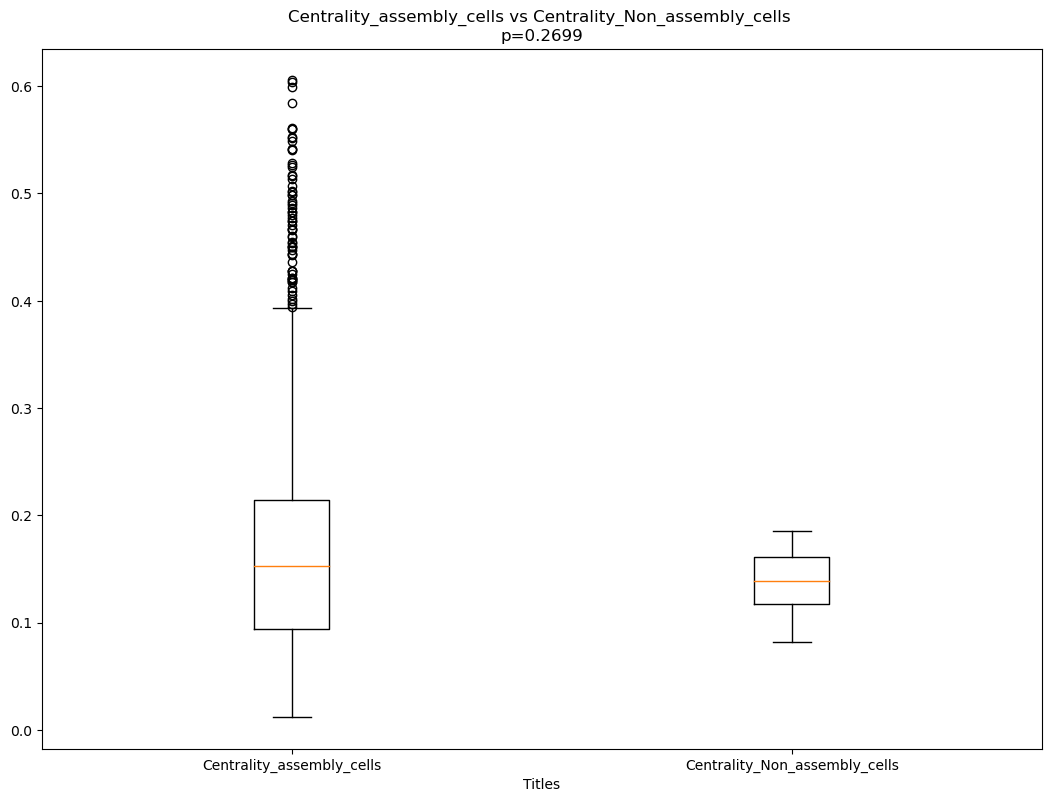

In [42]:
import matplotlib.pyplot as plt
from scipy.stats import ranksums

data = [centrality_assembly_cells, centrality_non_assembly_cells]

stat, p_value = ranksums(centrality_assembly_cells, centrality_non_assembly_cells, 'greater')

titles = ['Centrality_assembly_cells', 'Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [43]:
#---------------------------------plots for in-degree------------------------------------

indegree_centrality_assembly_cells = []
indegree_centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, in_cent in zip(cell_table['assembly_id'], cell_table['indegree_centrality']):
  if  idx != ['No A']:    
   #print(idx)
   #print(idx)
   indegree_centrality_assembly_cells.append(in_cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    indegree_centrality_non_assembly_cells.append(in_cent)

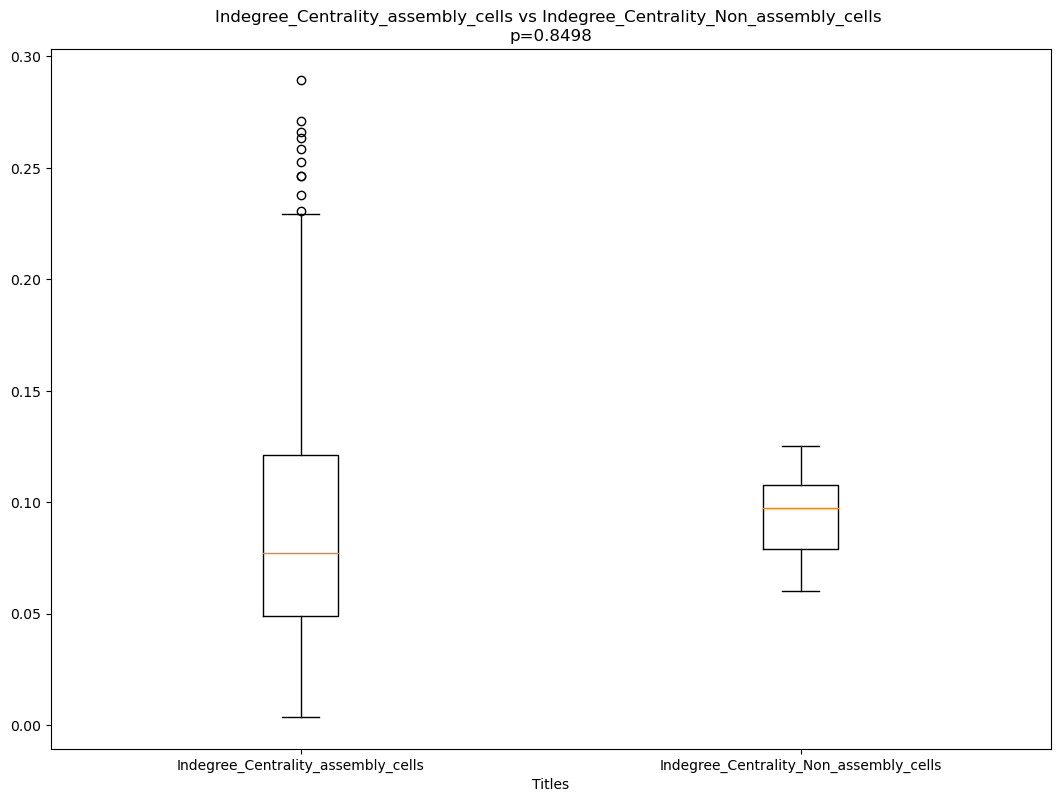

In [48]:
data = [indegree_centrality_assembly_cells, indegree_centrality_non_assembly_cells]

stat, p_value = ranksums(indegree_centrality_assembly_cells, indegree_centrality_non_assembly_cells, 'greater')

titles = ['Indegree_Centrality_assembly_cells', 'Indegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [49]:
#---------------------plots for out-degree---------------------------------

outdegree_centrality_assembly_cells = []
outdegree_centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, out_cent in zip(cell_table['assembly_id'], cell_table['outdegree_centrality']):
  if idx != ['No A']:    
   #print(idx)
   #print(idx)
   outdegree_centrality_assembly_cells.append(out_cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    outdegree_centrality_non_assembly_cells.append(out_cent)

0.08967695773961758
0.046466503267973865
0.08123556168596474
0.012867241797747295


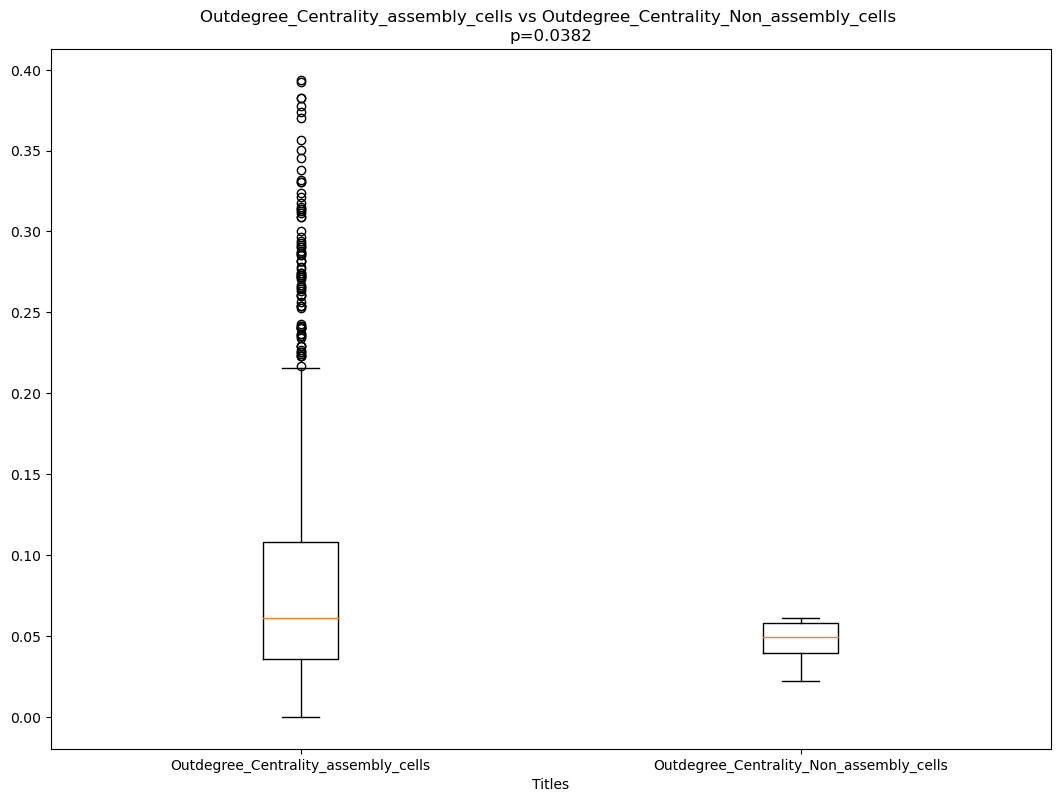

In [54]:
data = [outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells]

stat, p_value = ranksums(outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells, 'greater')
print(np.mean(outdegree_centrality_assembly_cells))
print(np.mean(outdegree_centrality_non_assembly_cells))
print(np.std(outdegree_centrality_assembly_cells))
print(np.std(outdegree_centrality_non_assembly_cells))
titles = ['Outdegree_Centrality_assembly_cells', 'Outdegree_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [55]:
#statistical test
stat = ranksums(outdegree_centrality_assembly_cells, outdegree_centrality_non_assembly_cells)
stat.pvalue

0.07638062149780375

In [51]:
closeness_centrality_assembly_cells = []
closeness_centrality_non_assembly_cells = []
idx_check_non_assembly = []

for idx, close_cent in zip(cell_table['assembly_id'], cell_table['closeness_centrality']):
  if idx != ['No A']:    
   #print(idx)
   #print(idx)
   closeness_centrality_assembly_cells.append(close_cent)
  else:
    #print(idx)
    #print(cent)
    idx_check_non_assembly.append(idx)
    closeness_centrality_non_assembly_cells.append(close_cent)

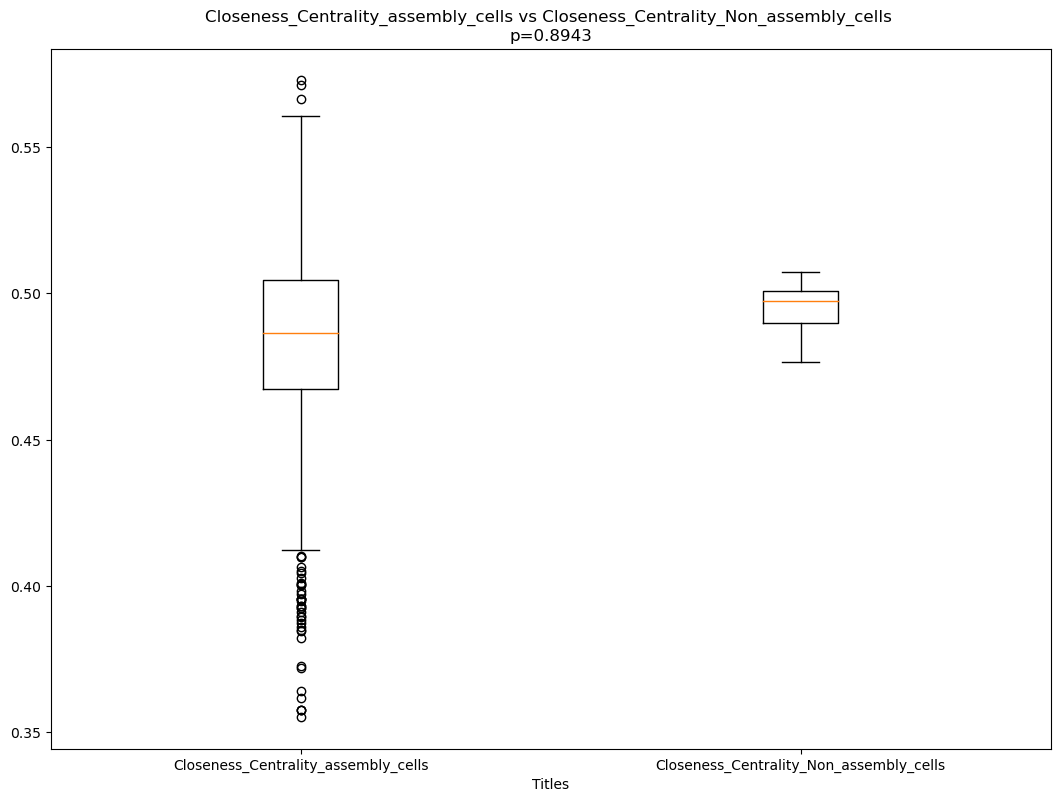

In [52]:
#-----------------------------plot for closeness centrality ----------------------------------
data = [closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells]

stat, p_value = ranksums(closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells, 'greater')
titles = ['Closeness_Centrality_assembly_cells', 'Closeness_Centrality_Non_assembly_cells']

fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# show plot
ax.set_xticklabels(titles)

# Set the x-axis label
plt.xlabel('Titles')
plt.title(f'{titles[0]} vs {titles[1]} \np={p_value:.4f}')
plt.show()

In [33]:
#stat test
stat = ranksums(closeness_centrality_assembly_cells, closeness_centrality_non_assembly_cells)
stat.pvalue

0.2584845873534536